1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.11.1 tensorflow-io==0.31.0 matplotlib

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

2. Build the Data Loding Function

In [2]:
CAPUCHIN_FILE = os.path.join("D:/GitProjects\Audio Classification/Parsed_Capuchinbird_Clips/XC3776-3.wav")
NOT_CAPUCHIN_FILE = os.path.join("D:/GitProjects\Audio Classification/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav")


In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

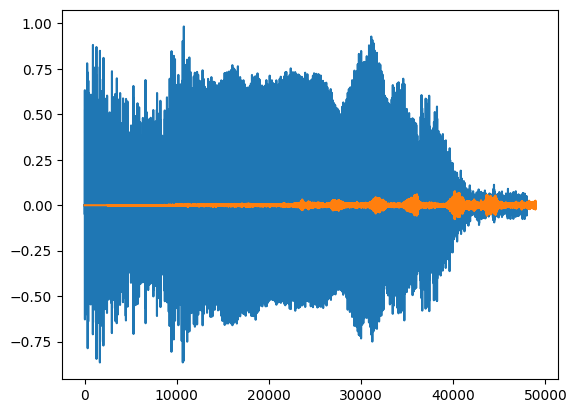

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

3. Create Tensorflow Dataset

In [6]:
POS = os.path.join("D:/GitProjects\Audio Classification/Parsed_Capuchinbird_Clips")
NEG = os.path.join("D:/GitProjects\Audio Classification/Parsed_Not_Capuchinbird_Clips")

In [7]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

4. Determine Average Length of a Capuchin Call

In [21]:
lengths = []
for file in os.listdir(os.path.join('D:/GitProjects\Audio Classification/Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('D:/GitProjects\Audio Classification/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [24]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [25]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [26]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

5. Build Preprocessing Function to Convert to Spectrogram

In [27]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [28]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()


In [29]:
spectrogram, label = preprocess(filepath, label)

In [30]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[4.76135463e-02],
        [1.12051882e-01],
        [1.68293923e-01],
        ...,
        [7.99886766e-05],
        [3.92552829e-05],
        [1.15036964e-05]],

       [[8.79892334e-02],
        [1.01873904e-01],
        [1.33787200e-01],
        ...,
        [7.56484515e-05],
        [3.15814759e-05],
        [4.14773822e-05]],

       [[7.53568485e-02],
        [8.65327641e-02],
        [1.03740834e-01],
        ...,
        [8.94375407e-05],
        [6.65350453e-05],
        [3.12924385e-06]],

       ...,

       [[8.09486210e-01],
        [6.69790864e-01],
        [3.91213298e-01],
        ...,
        [7.28278101e-05],
        [5.69997865e-05],
        [8.76188278e-06]],

       [[9.43948984e-01],
        [7.80529022e-01],
        [4.26150501e-01],
        ...,
        [3.74534429e-05],
        [6.35180622e-05],
        [3.24845314e-06]],

       [[1.04488707e+00],
        [8.35261166e-01],
        [4.02441442e-01]

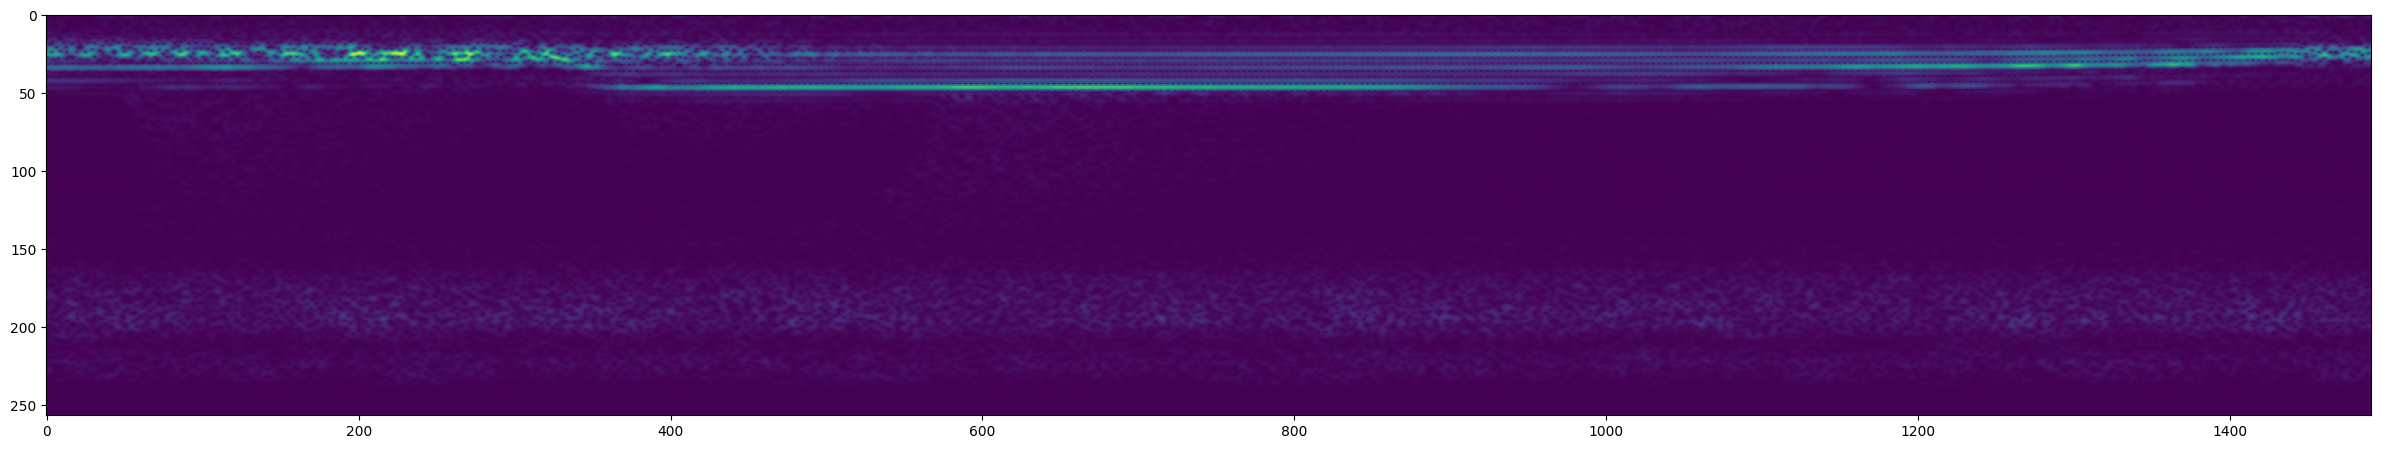

In [31]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

6. Create Training and Testing Partitions

In [32]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [33]:
train = data.take(36)
test = data.skip(36).take(15)

In [34]:
samples, labels = train.as_numpy_iterator().next()

7. Build Deep Learning Model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [39]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


8. Fit Model, View Loss and KPI Plots

In [42]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 287s 8s/step - loss: 5.0085 - recall: 0.8333 - precision: 0.7602 - val_loss: 0.1101 - val_recall: 0.9863 - val_precision: 0.8780
Epoch 2/4
36/36 [==============================] - 275s 8s/step - loss: 0.0896 - recall: 0.9536 - precision: 0.9863 - val_loss: 0.0278 - val_recall: 0.9848 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 276s 8s/step - loss: 0.0442 - recall: 0.9935 - precision: 0.9935 - val_loss: 0.0425 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 281s 8s/step - loss: 0.0175 - recall: 0.9932 - precision: 1.0000 - val_loss: 0.0056 - val_recall: 1.0000 - val_precision: 1.0000


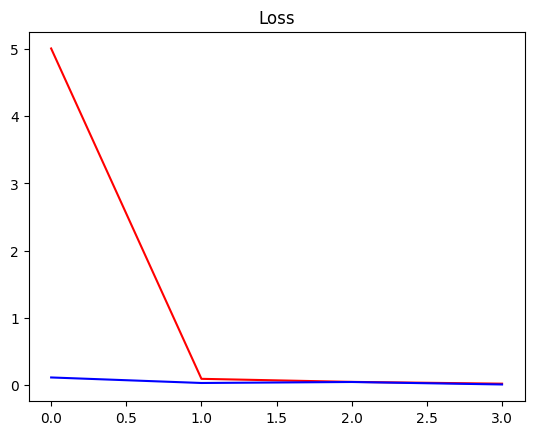

In [43]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

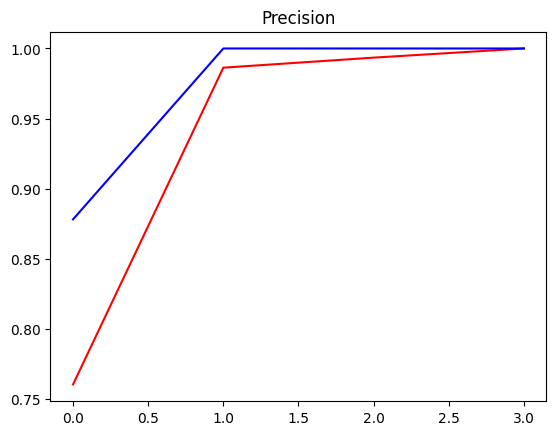

In [44]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

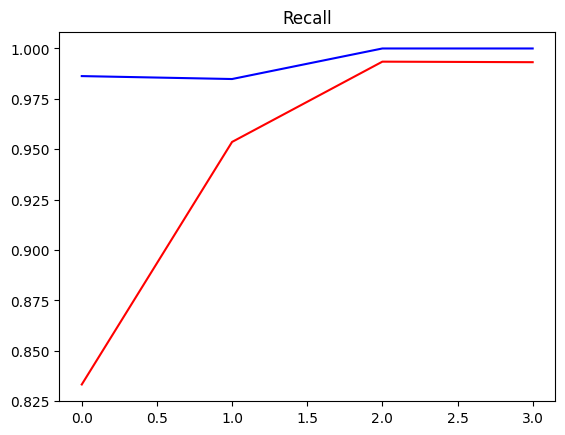

In [45]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [46]:
hist.history

{'loss': [5.008506774902344,
  0.08964521437883377,
  0.044240739196538925,
  0.017491092905402184],
 'recall': [0.8333333134651184,
  0.9536423683166504,
  0.9934640526771545,
  0.9931972622871399],
 'precision': [0.7602339386940002,
  0.9863013625144958,
  0.9934640526771545,
  1.0],
 'val_loss': [0.11005178838968277,
  0.027789710089564323,
  0.04250317066907883,
  0.005587216932326555],
 'val_recall': [0.9863013625144958, 0.9848484992980957, 1.0, 1.0],
 'val_precision': [0.8780487775802612, 1.0, 1.0, 1.0]}

9. Make a Prediction on a Single Clip

In [47]:
X_test, y_test = test.as_numpy_iterator().next()

In [48]:
X_test.shape

(16, 1491, 257, 1)

In [49]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 691ms/step


In [50]:
yhat

array([[9.0998882e-25],
       [1.0000000e+00],
       [3.7513998e-21],
       [6.4279225e-18],
       [1.3990735e-02],
       [1.4552983e-09],
       [9.9999988e-01],
       [3.2465116e-03],
       [1.2964081e-12],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.3088665e-13],
       [1.0000000e+00],
       [3.8967903e-15],
       [1.4147769e-18],
       [1.3483219e-05]], dtype=float32)

In [51]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [52]:
yhat

[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]

10. Build Forest Parsing Functions

10.1 Load up MP3s

mp3 = os.path.join('D:/GitProjects/Audio Classification/Forest Recordings/recording_00.mp3')

In [83]:
wav = load_mp3_16k_mono(mp3)

In [84]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [85]:
samples, index = audio_slices.as_numpy_iterator().next()

In [86]:
len(audio_slices)

60

10.2 Build Function to Convert Clips into Windowed Spectrograms

In [87]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

10.3 Convert Longer Clips into Windows and Make Predictions

In [88]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [93]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 3s 3s/step


In [94]:
yhat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [95]:
len(yhat)

60

In [96]:
from itertools import groupby

In [97]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [100]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [101]:
calls

5

11. Make Prediction

In [102]:
results = {}
for file in os.listdir(os.path.join('D:/GitProjects/Audio Classification/Forest Recordings')):
    FILEPATH = os.path.join('D:/GitProjects/Audio Classification/Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 2s 2s/step


In [103]:
results

{'recording_00.mp3': array([[1.3719633e-01],
        [3.8776468e-02],
        [1.9545156e-01],
        [3.5858136e-01],
        [1.0000000e+00],
        [1.1512794e-02],
        [5.1109649e-02],
        [5.1252872e-02],
        [5.5079445e-02],
        [1.0427970e-01],
        [9.3340538e-02],
        [1.1220675e-01],
        [5.9999052e-02],
        [9.9334019e-01],
        [1.0000000e+00],
        [3.3082455e-02],
        [4.6924464e-03],
        [5.9701946e-02],
        [1.3011135e-01],
        [1.3474311e-01],
        [7.2771914e-02],
        [5.8425408e-02],
        [1.5247637e-01],
        [8.2517707e-01],
        [1.0000000e+00],
        [8.1581585e-03],
        [3.4939397e-02],
        [7.4286245e-02],
        [2.5453648e-02],
        [7.8307033e-02],
        [7.0620112e-02],
        [8.5108601e-02],
        [2.1750282e-02],
        [4.4230293e-03],
        [8.2134463e-02],
        [2.4505038e-02],
        [1.0000000e+00],
        [9.1355905e-04],
        [7.8557871e-02],
     

12. Convert Predictions to classes

In [104]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

13. Group Detections according to sudio clips

In [105]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 2,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 13,
 'recording_18.mp3': 9,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 2,
 'recording_29.mp3': 4,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 13,
 'recording_39.mp3': 1,
 'recording_40.mp3': 1,
 'recording_4